# Human proteins Network



In [1]:
import csv
import scipy 
from scipy import sparse
import scipy.sparse.linalg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
from networkx.algorithms.community.quality import performance, coverage
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
import community
from collections import defaultdict

The following lines of code are used to import the adjacency matrix of the human proteins network. 
Then, a scipy sparse matrix is created to store such matrix.

### Import Adjacency matrix

In [2]:
class Network():
    
    def __init__(self,filename):
        self.filename = filename
        self.import_Network()
        
    def import_Network(self):

        list_rows=[]

        with open(self.filename) as tsvfile:
            reader = csv.DictReader(tsvfile, dialect='excel-tab')
            for row in reader:
                s = row['% asym unweighted'].split()
                list_rows.append(list(map(int, s)) )
    
        vals = np.array(list_rows)

        self.row = vals[:,0]
        self.col = vals[:,1]
        self.data = np.ones(vals.shape[0])
        self.num_vertices = int(np.max(self.col)) + 1
        self.num_edges = int(np.sum(self.data))
        
        
        self.adjacency = scipy.sparse.csr_matrix( (self.data, (self.row,self.col)), 
                                                 shape = (self.num_vertices,self.num_vertices))
        self.set_laplacian_matrix()
        
        
    def set_laplacian_matrix(self):
        out_degree = self.get_outdegree()
        
        self.laplacian = scipy.sparse.lil_matrix((self.num_vertices,self.num_vertices))
        self.laplacian.setdiag(np.array(out_degree).flatten())
        self.laplacian = self.laplacian - scipy.sparse.lil_matrix(self.adjacency)
        self.laplacian = scipy.sparse.csr_matrix(self.laplacian)        
        
        
    def get_indegree(self):
        degs = self.adjacency.sum(axis = 0)
        return degs.flatten()
    
    def get_outdegree(self):
        degs = self.adjacency.sum(axis = 1)
        return degs.flatten()
    

net = Network('out.maayan-figeys')


In [3]:
G = nx.from_scipy_sparse_matrix(net.adjacency, create_using = nx.DiGraph())

In [4]:
print('number of vertices: ', G.number_of_nodes(), 'number of edges', G.number_of_edges())

number of vertices:  2240 number of edges 6452


We can also try to visualize the graph where the size of the nodes is proportional to its degree

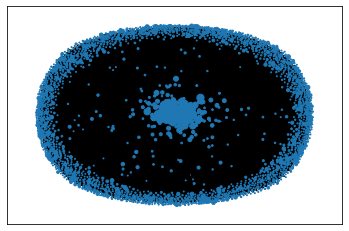

In [16]:
d = dict(G.degree)

nx.draw_networkx(G, with_labels=False, nodelist=list(d.keys()), node_size=[v for v in d.values()])
plt.show()

# 1. Centralities

We will calculate (and try to visualize) different node centralities.


## 1.1 Homogeneous centralities

There are not outstanding nodes.


### 1.1.1 Closeness centrality

Closeness centrality $C(u)$ of a node $u$ is the reciprocal of the average shortest path distance to $u$ over all $n-1$ reachable nodes.

$$ C(u) = \frac{n-1}{N-1} \frac{n-1}{\sum_{v=1}^{n-1} d(v,u)} $$

where $N$ is the number of nodes in the graph. 

We draw the network with sizes proportional to the closeness centrality

In [6]:
CC = nx.closeness_centrality(G)
nodes_CC = np.argsort(list(CC.values()))

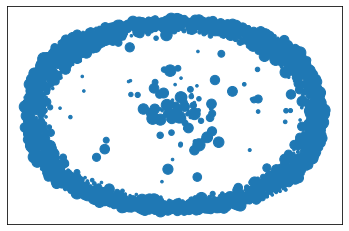

In [24]:
nx.draw_networkx_nodes(G,pos = nx.spring_layout(G), with_labels=False, node_size=[v*15000 for v in CC.values()])
plt.show()

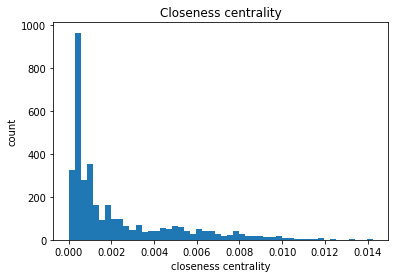

In [55]:
plt.hist(CC.values(), bins=50, density=True)
plt.title("Closeness centrality")
plt.xlabel( 'closeness centrality')
plt.ylabel('count')
plt.show()

Most of the nodes have similar closeness centrality.

### 1.1.2. Page-rank centrality

The page-rank centrality of a node tries to balance the number of links the node receives, the link propensity of the linkers and the centrality of the linkers. The page-rank centrality of a node $x_i$ is computed as follows:

$$
PR(x_i) = \alpha \sum_j a_{ji}\frac{x_j}{L(j)}+\frac{1-\alpha}{N},
$$
where $N$ is the number of nodes, $L(j)$ is the out-degree of the $j$-th node and $\alpha\in[0,1]$. It is very common to take $\alpha=0.85$.

We draw the network with sizes proportional to the page-rank centrality.

In [7]:
PRC = nx.pagerank(G)
nodes_PRC = np.argsort(list(PRC.values()))

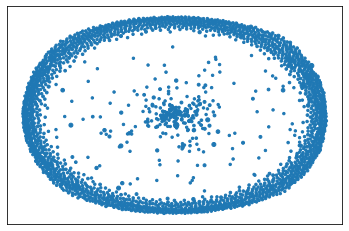

In [30]:
nx.draw_networkx_nodes(G,pos = nx.spring_layout(G), with_labels=False, node_size=[v*1.5e4 for v in PRC.values()])
plt.show()

We observe that all nodes have a similar page rank centrality. It is due to the fact that the vector of page-rank centralities adds up to 1 and there are a lot of nodes, so the mass gets quite shared.

Let us now highlight the 10 nodes with highest centrality by plotting them in red. Moreover, we are going to increase a bit the size of the nodes, while keeping it related with its centrality value.

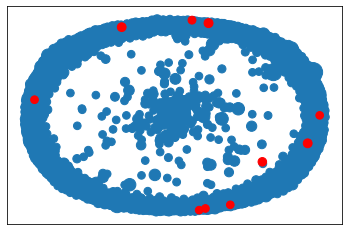

In [31]:
nx.draw_networkx_nodes(G,pos = nx.spring_layout(G), with_labels=False, node_size=[v*1.5e5 for v in PRC.values()])
max_list = list({k: v for k, v in sorted(PRC.items(), key=lambda item: item[1], reverse=True)[0:10]}.keys())
sub_G = G.subgraph(max_list)
nx.draw_networkx_nodes(sub_G, pos = nx.spring_layout(G), with_labels=False, node_color='r',
                      node_size=[v*1.5e5 for v in PRC.values()])
plt.show()

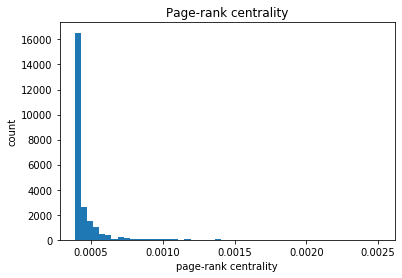

In [58]:
plt.hist(PRC.values(), bins=50, density=True)
plt.title("Page-rank centrality")
plt.xlabel( 'page-rank centrality')
plt.ylabel('count')
plt.show()

### 1.1.3. Katz centrality

Katz centrality generalizes degree centrality by measuring the number of nodes that are reachable while weighting them accoriding to their proximity. That is, it penalizes those who are further. The Katz centrality of the $i$-th node is defined as

$$
KC(x_i) = \left[ \sum_{k=0}^\infty \left( \alpha^kA^k \right)\boldsymbol{e} \right]_i,
$$

where $\boldsymbol{e}=(1,1,...,1)^T$.

We draw the network with sizes proportional to the Katz centrality. In addition, we are going to plot in red the nodes with highest centrality.

In [8]:
KC = nx.katz_centrality(G)
nodes_KC = np.argsort(list(KC.values()))

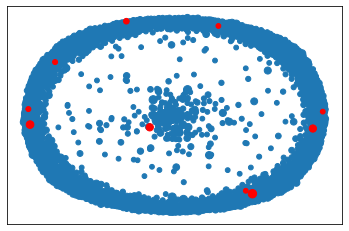

In [33]:
nx.draw_networkx_nodes(G,pos = nx.spring_layout(G), with_labels=False, node_size=[v*1.5e3 for v in KC.values()])
max_list = list({k: v for k, v in sorted(KC.items(), key=lambda item: item[1], reverse=True)[0:10]}.keys())
sub_G = G.subgraph(max_list)
nx.draw_networkx_nodes(sub_G, pos = nx.spring_layout(G), with_labels=False, node_color='r',
                      node_size=[v*1.5e3 for v in KC.values()])
plt.show()

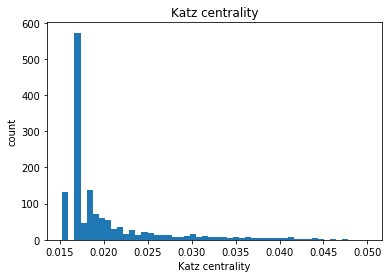

In [59]:
plt.hist(KC.values(), bins=50, density=True)
plt.title("Katz centrality")
plt.xlabel( 'Katz centrality')
plt.ylabel('count')
plt.show()

We observe that all the nodes have a very similar Katz centrality value.

## 1.2 Not homogeneous centralities

We can find outstanding nodes

### 1.2.1 Betweenness centrality 

Betweenness centrality of a node $v$ is the sum of the fraction of all-pairs shortest paths that pass through $v$:

$$
c_B(v) = \sum_{s,t \in V} \frac{\sigma(s,t|v)}{\sigma(s,t)}
$$

where $V$ is the set of nodes, $\sigma(s,t)$ is the number of shortest $(s,t)$-paths, and $\sigma(s,t|v)$ is the number of those paths passing through some node $v$ other than $s,t$. If $s=t$, $\sigma(s,t)=1$, and if $v \in s,t$,  $\sigma(s,t|v)=0$. 

We draw the network with sizes proportional to the betweeness centrality

In [9]:
CB = nx.betweenness_centrality(G)
nodes_CB = np.argsort(list(CB.values()))

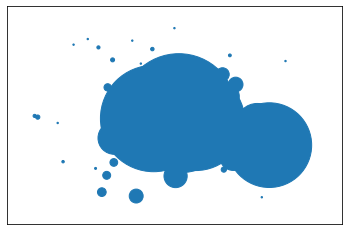

In [26]:
nx.draw_networkx_nodes(G,pos = nx.spring_layout(G), with_labels=False, node_size=[v*1e7 for v in CB.values()])
plt.show()

There are very few nodes with high betweeness centrality. Their betweeness centrality is two or three orders of magnitude larger than the other nodes' betweeness centrality.

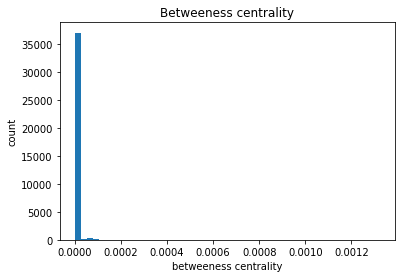

In [56]:
plt.hist(CB.values(), bins=50, density=True)
plt.title("Betweeness centrality")
plt.xlabel( 'betweeness centrality')
plt.ylabel('count')
plt.show()

### 1.2.2. Eigenvector centrality

Eigenvector centrality computes the centrality for a node based on the centrality of its neighbors. The eigenvector centrality for node $i$ is the $i-th$ element of the vector $x$ defined by the equation

$$
Ax = \lambda x
$$

where $A$ is the adjacency matrix of the graph $G$ with eigenvalue $\lambda$. By virtue of the Perron–Frobenius theorem, there is a unique solution $x$, all of whose entries are positive, if $\lambda$ is the largest eigenvalue of the adjacency matrix $A$.

We draw the network with sizes proportional to the eigenvector centrality.

In [10]:
EC = nx.eigenvector_centrality(G)
nodes_EC = np.argsort(list(EC.values()))

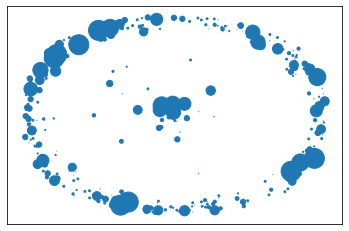

In [28]:
nx.draw_networkx_nodes(G,pos = nx.spring_layout(G), with_labels=False, node_size=[v*1.5e3 for v in EC.values()])
plt.show()

Notice that there are few nodes with high eigenvector centrality.

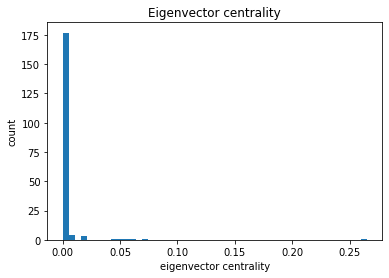

In [57]:
plt.hist(EC.values(), bins=50, density=True)
plt.title("Eigenvector centrality")
plt.xlabel( 'eigenvector centrality')
plt.ylabel('count')
plt.show()

### 1.2.3. Clustering

The clustering coefficient of a node provides information about the clustering tendency of its neighbors. The clustering coefficient of the $i$-th node is computed as:

$$
CLT(x_i)=\frac{\text{#triangles connected to $i$}}{\text{#possible triangles connected to $i$}}.
$$

Let us begin by computing the average clustering coefficient for the graph.

In [34]:
nx.average_clustering(G)

0.022991199720053465

Let us now draw the network with sizes proportional to the clustering coefficient. In addition, we are going to use different colors to help visualization. The nodes whose coefficients are zero, will be plotted with small red dots.

In [11]:
CLT = nx.clustering(G)
nodes_CLT = np.argsort(list(CLT.values()))

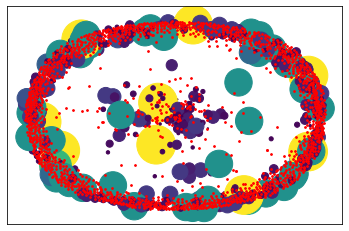

In [36]:
nx.draw_networkx_nodes(G,pos = nx.spring_layout(G), with_labels=False, node_color=[v*10 for v in CLT.values()],
                      node_size = [v*1.5e3 for v in CLT.values()])
zero_nodes = [k for k, v in CLT.items() if v == 0]
sub_G = G.subgraph(zero_nodes)
nx.draw_networkx_nodes(sub_G, pos = nx.spring_layout(G), with_labels=False, node_color='r',
                      node_size=3)
plt.show()

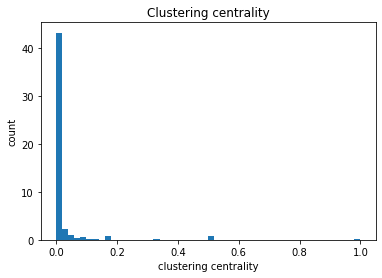

In [60]:
plt.hist(CLT.values(), bins=50, density=True)
plt.title("Clustering centrality")
plt.xlabel( 'clustering centrality')
plt.ylabel('count')
plt.show()

Notice that there is a wide variety of behaviors. 

## 1.3 Importance of the nodes

In [75]:
print('top 10 nodes with highest closeness centrality', nodes_CC[:10])
print('top 10 nodes with highest page-rank centrality', nodes_PRC[:10])
print('top 10 nodes with highest Katz centrality', nodes_KC[:10])

top 10 nodes with highest closeness centrality [   0  411 1621 1623  401  398  395 1637  392 1639]
top 10 nodes with highest page-rank centrality [   0  325  915  917  931  943  988 1031  314  175]
top 10 nodes with highest Katz centrality [   0  411 1621 1623  401  398  395 1637  392 1639]


In [72]:
print('top 10 nodes with highest betweeness centrality', nodes_CB[:10])
print('top 10 nodes with highest eigenvector centrality', nodes_EC[:10])
print('top 10 nodes with highest clustering centrality', nodes_CLT[:10])

top 10 nodes with highest betweeness centrality [   0 1502 1501 1500 1499 1498 1497 1496 1495 1494]
top 10 nodes with highest eigenvector centrality [   0  411 1621 1623  401  398  395 1637  392 1639]
top 10 nodes with highest clustering centrality [   0 1503 1502 1501 1500 1499 1498 1497 1496 1495]


The first thing we notice is that the first node has the highest of all the centralities. It may correspond to a very common protein that interacts with many other proteins. 

Apart from that, we notice that there are mainly three groups of nodes:


+ The nodes with highest eigenvector, closeness and Katz centrality. These centralities all take into account the distance to the reachable nodes. For this reason it is expectable that some nodes will have a high value for these three measures. 

+ The nodes with highest betweenes and clustering. These centralities do not measure the distance of the reachable nodes, but the strucuture (or topology) of the network.  For this reason it is expectable that some nodes will have a high value for these measures.

+ The nodes with higest page-rank centrality. The page-rank centrality is very homogeneous among all nodes. Therefore, there are not outstanding nodes with high centrality values, and the top ten values may be just some random nodes. 

# 2. Macroscale properties

## 2.1. Clustering

Now we will look at clustering properties of the network.

Remember the definition of the clustering coefficient of a node:

### Clustering coefficient of a node

$$
C_i = \frac{2\cdot E_i}{k_i(k_i-1)}
$$

where $E_i$ is the number of triangles of node $i$, and $k_i(k_i-1)$ represents the total number of triangles that the node could possibly have, being $k_i$ the node's degree. 

With this deffinition we can define the *global* clustering coefficient of the network.

### Clustering of the network

$$
C = \frac{1}{N} \sum_{i=1}^N C_i,
$$
where $N$ is the total number of nodes of the graph. Notice that it is the average clustering coefficient of all nodes.

In [17]:
print('Average clustering coefficient:', nx.average_clustering(G))

Average clustering coefficient: 0.022991199720053465


We can also inspect the clustering coefficient of a node as a function of the degree of such nodes.

In [18]:
clus = nx.clustering(G)
deg = dict(G.degree())

In [19]:
idx = np.argsort(list(deg.values()))

deg_vals = np.array(list(deg.values()))[idx]
clus_vals = np.array(list(clus.values()))[idx]

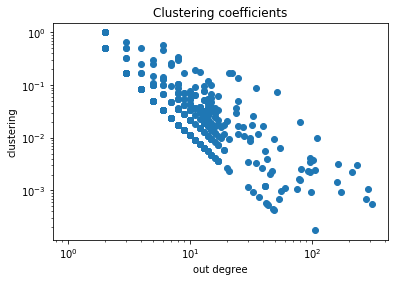

In [20]:
plt.plot(deg_vals, clus_vals, 'o')
plt.xscale('log')
plt.yscale('log')
plt.title("Clustering coefficients")
plt.xlabel('out degree')
plt.ylabel('clustering')
plt.show()

We observe some descreasing tendency. This happens because as the number of connection increases, it becomes more unlikely that the neighbours of a node are also connected. For this reason, we expect the clustering coefficient to decrease with the degree of the node.

### Newman Clustering Coefficient


It is also known as the transitivity index of the network. It is the fraction of all possible triangles present in G. Possible triangles are identified by the number of “triads” (two edges with a shared vertex).

In [23]:
print('The Newman clustering coefficient is: ', nx.transitivity(G))

The Newman clustering coefficient is:  0.0015705864234240004


We observe that it is smaller than the clustering coefficient, but of the same order. The clustering coefficient quantifies how clustered is the network locally, while the Newman clustering coefficient quantifies how clustered is the network as a whole.

## 2.2. Degree Distribution

We will compute $P(k)$, that is, the probability that a randomly selected node has degree $k$. It is a measure in the spread the number of links the nodes have. 

In [24]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True) 

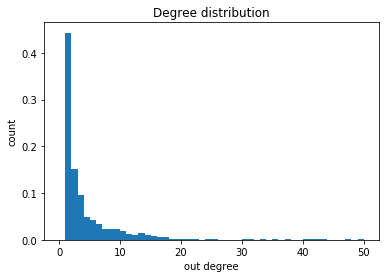

In [25]:
plt.hist(degree_sequence, bins=50, density=True, range=(0,50))
plt.title("Degree distribution")
plt.xlabel('out degree')
plt.ylabel('count')
plt.show()

We can see that with this histogram it is very hard to see the actual distribution of $P(k)$.

We observe that there are a lot of nodes with zero degree, and then the number decreases to zero. 

We want to see if the decrease to zero is exponential or if it follows a power low.

First of all, we plot the same histogram using a log-log scale.

In [28]:
coef = np.polyfit(np.log10(hist[1][2:26]),np.log10(hist[0][1:25]),1)
poly1d_fn = np.poly1d(coef) 

print('Slope of linear fit: ', coef[0])

Slope of linear fit:  -2.422838637957744


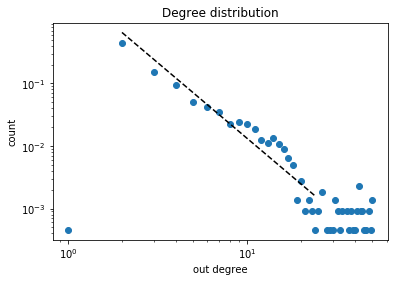

In [29]:
plt.plot(hist[1][1:],hist[0], 'o')
plt.plot(hist[1][2:25], np.power(10,poly1d_fn(np.log10(hist[1][2:25]))), '--k')
plt.xscale('log')
plt.yscale('log')
plt.title("Degree distribution")
plt.xlabel('out degree')
plt.ylabel('count')
plt.show()

We observe that more or less until degree 11, the distribution decays following a power low. For degrees larger than 11, there are very few nodes with such large degree, and therefore the probabilty of having such degree stabilizes.

The slope of the linear fit if of around -2.3.

## 2.3. Robustness

Let us begin by defining some notation by following the paper "Attack Robustness and Centrality of Complex Networks" that was introduced on the slides. Let $G$ be a graph and $N$ the total number of nodes. Let $N_\rho$ be the network that results from removing a fraction $\rho$ of the vertices according to some specified procedure. We will denote by $N_\rho '$ the largest component of $N_\rho$. Then, we define
$$
\sigma(\rho) = \frac{|N_\rho '|}{N},
$$
where |$N_\rho '$| is the number of nodes of the network $N_\rho '$. 

The robustness of a network may be measured by how $\sigma(\rho)$ varies as $\rho$ increases. In other words, it is measured by how the fractional size of its largest component varies when some fraction of the nodes are removed. The robustness of a network under this type of vertex removal can be quantified by the R-index, which is defined as follows
$$
R=\frac{1}{N}\sum_{i=1}^N\sigma(i/N).
$$
Then, we define the V-index, which measures the vulnerability of a network to a given scheme of vertex removal, to be the complementary quantity to R
$$
V = \frac{1}{2}-R.
$$

Notice that, so far, we have been assuming that the vertices are removed according to some specified procedure. The removal methods that we are going to consider are the following:
* **degree**: remove vertices according to their degrees, from highest to lowest.
* **random**: remove vertices randomly by following a uniform distribution.

In addition, we are going to use the centralities studied in the former notebook:
* **closeness**: remove vertices according to their values of closeness centrality, from highest to lowest.
* **betweenness**: remove vertices according to their values of betweeness centrality, from highest to lowest.
* **eigenvector**: remove vertices according to their values of eigenvector centrality, from highest to lowest.
* **page-rank**: remove vertices according to their values of page-rank centrality, from highest to lowest.
* **katz**: remove vertices according to their values of katz centrality, from highest to lowest.
* **clustering**: remove vertices according to their values of average clustering coefficient, from highest to lowest.

Let us now plot $\sigma(\rho)$ of our network by using the above removal procedures.

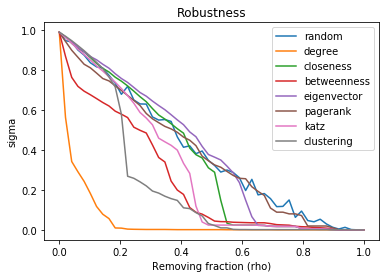

In [34]:
def random_nodes(gr):
    vals = np.random.permutation(len(gr.nodes))
    d = dict()

    for i in range(len(vals)):
        d[i] = vals[i]
    return d


removal_procedures = {'random': random_nodes,
                      'degree': lambda gr: dict(nx.degree(gr)), 
                      'closeness': nx.closeness_centrality,
                      'betweenness':  nx.betweenness_centrality,
                      'eigenvector': nx.eigenvector_centrality, 
                      'pagerank': nx.pagerank, 
                      'katz': nx.katz_centrality,
                      'clustering': nx.clustering}


    
ro_list = list(np.linspace(0.0, 1.0, num=50))
sigma = []
i = 0

for procedure in removal_procedures.keys():    
    for ro in ro_list:
        G_aux = G.copy()
        G_aux.remove_nodes_from(list(nx.isolates(G_aux))) #remove nodes that do not have in nor out neighbors
        N = G_aux.number_of_nodes() #total number of nodes

        #Remove the fraction ro
        centrality = removal_procedures[procedure](G_aux)
        idx = np.argsort(list(centrality.values()))[::-1][:]
        nodes = list(centrality.keys())
        nodes_to_remove = [nodes[i] for i in idx][:int(ro*G_aux.number_of_nodes())]
        G_aux.remove_nodes_from(list(nodes_to_remove))

        #Take the largest component
        try: 
            largest_cc = max(nx.weakly_connected_components(G_aux), key=len)
            G_aux = G_aux.subgraph(largest_cc)
            #compute sigma
            sigma.append(G_aux.number_of_nodes()/N)
        except ValueError:
            sigma.append(0)
        
    #plot
    plt.plot(ro_list, sigma[i*50:(i+1)*50], label=procedure)
    plt.title("Robustness")
    plt.xlabel('Removing fraction (rho)')
    plt.ylabel('sigma')
    i += 1
plt.legend()
plt.show()

We can see that our network is more susceptible to the type of removal that targets the highest degree vertices. Such large-degree vertices (also called *hubs*), are the ones which give structure to the network. We have seen in the previous section that such nodes make the probability distribution of the degree heavy-tailed, so that the decreasing of the degree distribution follows a power law. Therefore, removing those large-degree nodes changes such probabiliy distribution, and therefore the structure of the network.  On the other hand, its highest robustness is achieved by regarding the page-rank centrality removal. We also observe that the network is very robust when removing the nodes randomly.

## 2.4. Correlations

The correlation between two nodes measure at which extent the degrees of the two nodes are related. Correlation can be computed in two different ways.

(i) **Assortativity Degree**: given a network, it measures at which extent the degree of a node is linearly related to its neighbors' degree. It takes values in the range [-1,1]. A coefficient of 1 stands for a total positive linear correlation, 0 is no linear correlation, and −1 is total negative linear correlation. It is computed as follows
$$
r = \frac{\langle k_ik_j \rangle-\langle k\rangle^2}{\langle k^2 \rangle-\langle k\rangle^2},
$$
where $\langle k\rangle$ is the average degree of the network, $\langle k^2\rangle$ is the average of the squared degree of the network and $\langle k_ik_j\rangle$ is the average of the product of the degrees of all pairs of neighboring nodes.

(ii) **Average Neighbor Degree**: given a node $i$, it is the average of its neighbor's degree. It is computed as follows
$$
k_{nn,i}=\frac{1}{|N(i)|}\sum_{j\in N(i)}k_j,
$$
where $|N(i)|$ is the number of nodes neighbouring $i$ and $k_j$ is the degree of node $j$. 

We distinguish three different types of networks depending on the values of $r$ and the behavior of the plot $k$-$k_{nn}$:
* Assortative: the plot displays an increasing tendency. It happens when the assortativity degree is positive.
* Disassortative: the plot displays a dencreasing tendency. It happens when the assortativity degree is negative.
* No structure: the plot does not display any particular structure. It happens when the assortativity degree is 0.


**Let us begin by computing the assortativity degree.**

In [35]:
print('Degree assortativity of the graph:', nx.degree_assortativity_coefficient(G))

Degree assortativity of the graph: -0.010965433440751684


Since the correlation coefficient is quite close to 0.

**Let us now compute the average neighbor degree.**

By taking logarithms, we expect a relation given by
$$
\log(k_{nn}(k))\sim -\nu \log(k).
$$

Let us now plot it taking logarithms and perform a linear regression. Since the assortativity degree was -0.01, we expect our network not to be assortative nor disassortative. That is, we do not expect a linear relation between $k$ and $k_{nn}$. Therefore, $\nu$ should be close to 0.

In [37]:
AvNeigDegree = nx.average_neighbor_degree(G)
Degree = dict(G.degree)

In [39]:
import sklearn
from sklearn.linear_model import LinearRegression

In [40]:
x = []
for i in list(Degree.values()):
    if i != 0:
        x.append(np.log10(i))
    else:
        x.append(0)
        
y = []
for i in list(AvNeigDegree.values()):
    if i != 0:
        y.append(np.log10(i))
    else:
        y.append(0)
        
x = np.array(x).reshape(-1,1)
y = np.array(y).reshape(-1,1)

In [41]:
Linreg = LinearRegression().fit(x, y)

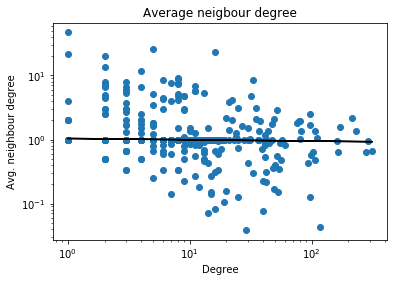

In [42]:
plt.plot(10**x, 10**y, 'o')
plt.plot(10**x, 10**Linreg.predict(x),color='k')
plt.title('Average neigbour degree')
plt.xlabel('Degree')
plt.ylabel('Avg. neighbour degree')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [43]:
print("The slope of the fitting line is {}".format(Linreg.coef_[0][0]))

The slope of the fitting line is -0.02019065730107143


As expected, the above plot does not display any type of structure. In other words, there is no linear correlation between $k$ and $k_{nn}$. In particular, the slope of the fitting line is $\nu\sim 0.006$.

# 3. Network Models

We can also define the graph using the NetworkX package.

In [4]:
G = nx.from_scipy_sparse_matrix(net.adjacency, create_using = nx.DiGraph())

In this notebook, we will explore different network models and compare their properties with our network properties. In particular, we will create *directed* networks according to a model, with the same number of nodes and edges as our network. Then, we will examine the probability **distribution of the degree**, the **average shortest path length** and the **clustering coefficient** of both models.

## 1. Random Network Model

There are two ways of defining this model, either using a fixed number of links, or using a probability of having a link between two nodes. We will explore both.

### Gilbert random graph model

The random network model has two parameters: the number of nodes $N$, and the link probability $p$. The algorithm for creating this network is as follows:

1. Select a pair of nodes, say i and j.
2. Generate a random number r between 0 and 1. If r < p, then add a link between i and j.
3. Repeat (1) and (2) for all pairs of nodes.

In this case, the expected number of links, $M$, is:

$$
\mathbb{E}[M] = p \frac{N(N-1)}{2}
$$

where $N$ is the number of nodes. We want to generate a network which is similar to ours. For this reason, we will use the same number of nodes and we will choose $p$ so that the expected number of links is equal to the number of links in our network. This leads to:

$$
p = \frac{2M}{N(N-1)}
$$

where $M$ is the number of links in our network.

Moreover, since our graph is directed we will also generate a directed graph.


In [5]:
N = G.number_of_nodes()
M = G.number_of_edges()
p = M/(N*(N-1))

G_Gil = nx.gnp_random_graph(N, p, directed=True)


Now we try to visualize both networks

**Gilbert Network:**

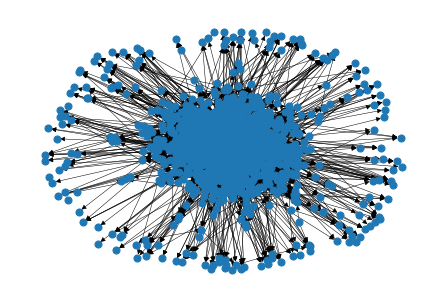

In [6]:
nx.draw(G_Gil, pos=nx.spring_layout(G_Gil), width = 0.5, node_size=50)

**Real Network:**

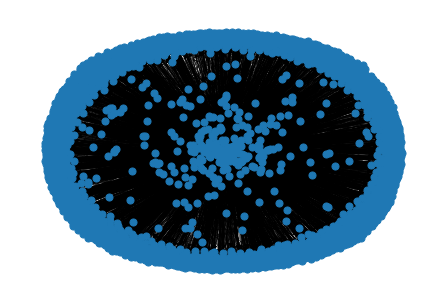

In [7]:
nx.draw(G, pos=nx.spring_layout(G), width = 0.5, node_size=50)

### Degree distribution

We will now compare the degree distribution of both networks.

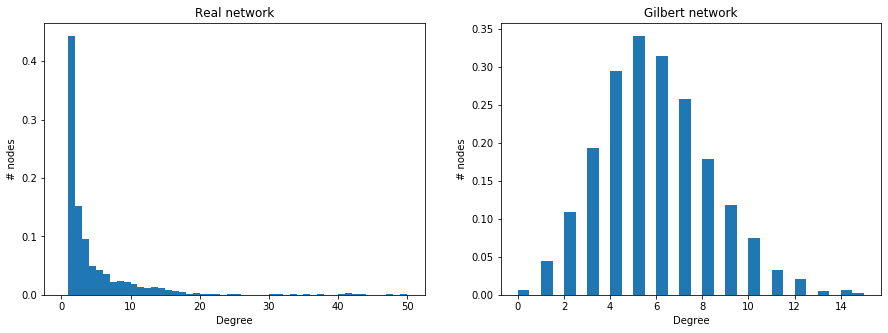

In [9]:
#Real network
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
degrees = dict(G.degree()).values() 
degree_hist = ax1.hist(list(degrees), 50, range=(0,50), density=True)
ax1.set_xlabel('Degree')
ax1.set_ylabel('# nodes')
ax1.set_title('Real network')


#Gilbert network
degrees_Gil = sorted([d for n, d in G_Gil.degree()], reverse=True) 
degree_hist_Gil = ax2.hist(list(degrees_Gil), 30 , density=True)
ax2.set_xlabel('Degree')
ax2.set_ylabel('# nodes')
ax2.set_title('Gilbert network')


plt.show()


We can see that the distributions are very different just by looking at the histogram.

Now we can plot the distributions in a log-log scale to see the decay of the distribution as the degree increases.

Slope of linear fit:  -2.422838637957744


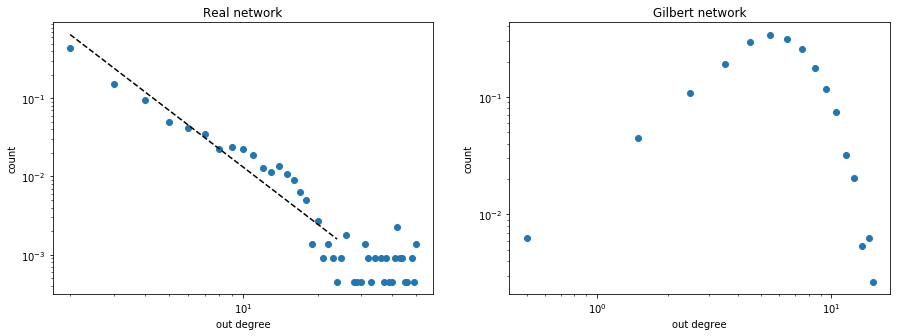

In [10]:
coef = np.polyfit(np.log10(degree_hist[1][2:26]),np.log10(degree_hist[0][1:25]),1)
poly1d_fn = np.poly1d(coef) 

print('Slope of linear fit: ', coef[0])

f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.plot(degree_hist[1][2:],degree_hist[0][1:], 'o')
ax1.plot(degree_hist[1][2:25], np.power(10,poly1d_fn(np.log10(degree_hist[1][2:25]))), '--k')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title("Real network")
ax1.set_xlabel('out degree')
ax1.set_ylabel('count')


ax2.plot(degree_hist_Gil[1][1:],degree_hist_Gil[0], 'o')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title("Gilbert network")
ax2.set_xlabel('out degree')
ax2.set_ylabel('count')

plt.show()

The previous plot shows that our network has a distribution degree which follows a power law of parameter approximately of 2.4. On the other hand, the Gilbert network clearly does not follow a power law decrease.
To show that it is in fact an exponential decrease, we will plot the degree distribution using log scale only in the x axis. Then, we will fit a linear model.

### Average length

We will compute the average shortest path lenght of the two models. In order to calculate it, we need to stick to a weakely connected component. We will choose the largest weakely connected component for both graphs.

In [12]:
largest_cc = max(nx.weakly_connected_components(G), key=len)
G_con = G.subgraph(largest_cc)

largest_cc_Gil = max(nx.weakly_connected_components(G_Gil), key=len)
G_con_Gil = G_Gil.subgraph(largest_cc_Gil)

print('Real network: Average shortest path length: ', nx.average_shortest_path_length(G_con))
print('Gilbert network: Average shortest path length: ', nx.average_shortest_path_length(G_con_Gil))

Real network: Average shortest path length:  0.018096339574896314
Gilbert network: Average shortest path length:  6.228132067536962


We observe that the average shortest path length of the Gilbert networks is much larger than the average shortest path length from the real network. 

### Clustering coefficient

Finally, we will compare the clustering coefficient of both networks.

In [13]:
print('Real network: Average clustering coefficient:', nx.average_clustering(G))
print('Gilbert network: Average clustering coefficient:', nx.average_clustering(G_Gil))

Real network: Average clustering coefficient: 0.022991199720053465
Gilbert network: Average clustering coefficient: 0.0013594800536764812


Notice that the average clustering coefficient is much higher for the real network than for the gilbert network. We expected this fact since the clustering property is not a random property, but a social property, and thus it is not present in a random network. 

## 2. Small-World Model

Let us now introduce another way of constructing random networks, which is the so called *small-world model*. It can be considered a crossover from regular lattices to random graphs. Its main objective is to provide the randomly generated network with two properties that are very common on real graphs: low average length and high clustering coefficient.

The algorithm for generating a small-world network is as follows:

1. Begin with a ring of $N$ nodes
2. Connect each node to its $k$ nearest neighbors (or $k-1$ if k is odd).
3. For each edge $(u, v)$, with probability $p$, replace edge $(u, v)$ with $(u, w)$ where $w$ is not a neighbor of $u$.

We will now construct small-world graphs with the same number of nodes and edges as our graph. Notice that the number of edges of such graphs will be $\frac{k}{2}N$. Therefore, if our graph has $M$ edges, then $k$ should be the integer part of $\frac{2M}{N}$. Therefore, it is highly probable that the randomly generated has a little less number of edges.

We are going to **create 3 different networks**, each one with **different values of $p$**: 0.2, 0.5 and 0.8. Observe that, as we increase the value of $p$, we are increasing its randomness.

In [14]:
N = G.number_of_nodes()
M = G.number_of_edges()
k = round(2*M/N)

G_SmWd_1 = nx.watts_strogatz_graph(n=N, k=k, p=0.2)
G_SmWd_2 = nx.watts_strogatz_graph(n=N, k=k, p=0.5)
G_SmWd_3 = nx.watts_strogatz_graph(n=N, k=k, p=0.8)

Let us now visualize the networks

**Real Network:**

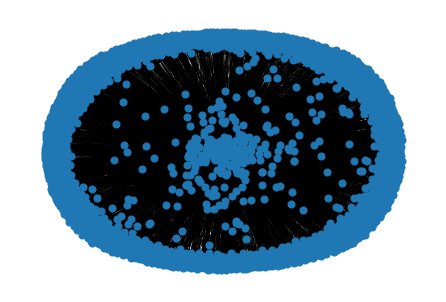

In [15]:
nx.draw(G, pos=nx.spring_layout(G), width = 0.5, node_size=50)

**Small-world Network with p=0.2:**

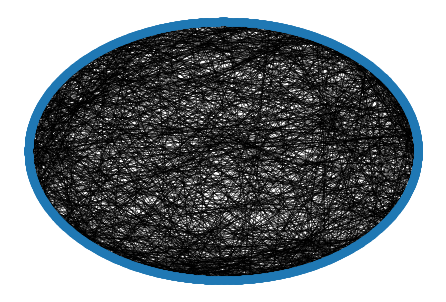

In [16]:
nx.draw(G_SmWd_1, pos=nx.circular_layout(G_SmWd_1), width = 0.5, node_size=50)

**Small-world Network with p=0.5:**

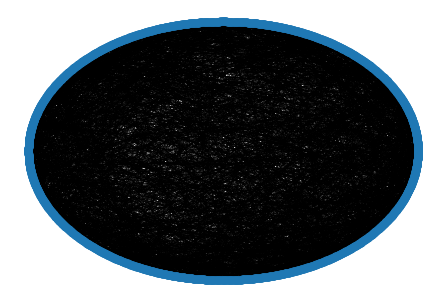

In [17]:
nx.draw(G_SmWd_2, pos=nx.circular_layout(G_SmWd_2), width = 0.5, node_size=50)

**Small-world Network with p=0.8:**

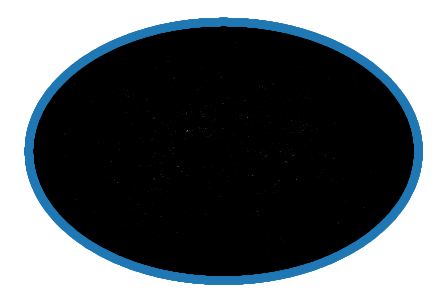

In [18]:
nx.draw(G_SmWd_3, pos=nx.circular_layout(G_SmWd_3), width = 0.5, node_size=50)

### Degree distribution

We will now compare the degree distribution of these networks. Recall that, in the previous case, we saw that our network followed a power-law distribution.

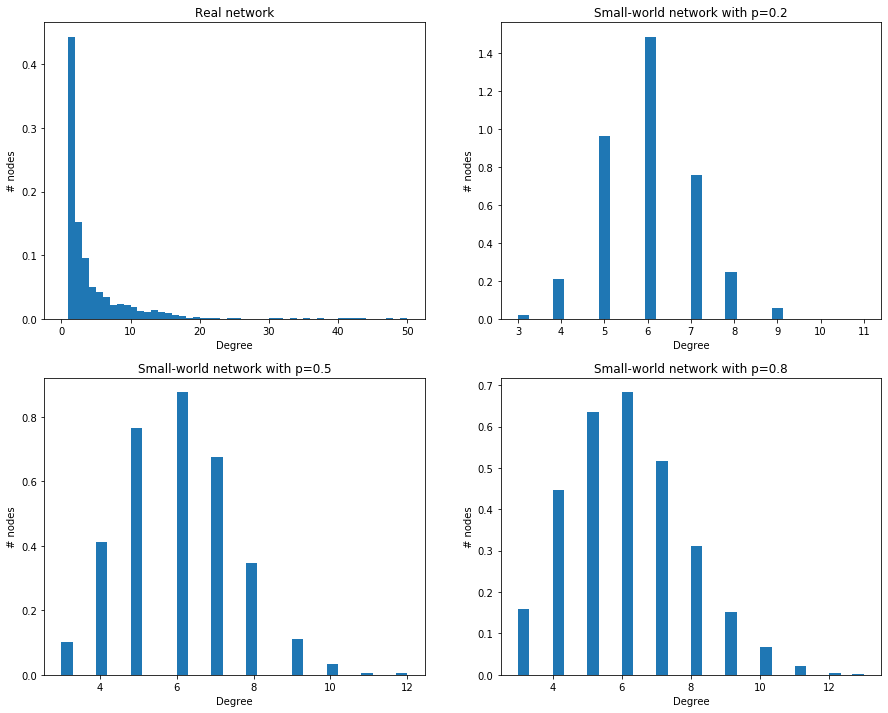

In [20]:
#Real network
f, (ax1, ax2) = plt.subplots(2, 2,figsize=(15,12))
degrees = dict(G.degree()).values() 
degree_hist = ax1[0].hist(list(degrees), 50, range=(0,50), density=True)
ax1[0].set_xlabel('Degree')
ax1[0].set_ylabel('# nodes')
ax1[0].set_title('Real network')


#Small-world networks
degrees_SmWd_1 = sorted([d for n, d in G_SmWd_1.degree()], reverse=True) 
degree_hist_SmWd_1 = ax1[1].hist(list(degrees_SmWd_1), 30 , density=True)
ax1[1].set_xlabel('Degree')
ax1[1].set_ylabel('# nodes')
ax1[1].set_title('Small-world network with p=0.2')

degrees_SmWd_2 = sorted([d for n, d in G_SmWd_2.degree()], reverse=True) 
degree_hist_SmWd_2 = ax2[0].hist(list(degrees_SmWd_2), 30 , density=True)
ax2[0].set_xlabel('Degree')
ax2[0].set_ylabel('# nodes')
ax2[0].set_title('Small-world network with p=0.5')

degrees_SmWd_3 = sorted([d for n, d in G_SmWd_3.degree()], reverse=True) 
degree_hist_SmWd_3 = ax2[1].hist(list(degrees_SmWd_3), 30 , density=True)
ax2[1].set_xlabel('Degree')
ax2[1].set_ylabel('# nodes')
ax2[1].set_title('Small-world network with p=0.8')


plt.show()


By looking at the histograms, we can see that the degree distribution of the small-world networks is not a power-law. This fact was already expected, since the power-low degree distribution is a feature of real graphs but not random graphs.

### Average length

We will compute the average shortest path lenght of the models. As we already did in the previous case, we will stick to the largest connected component for each graph.

In [21]:
#our network
largest_cc = max(nx.weakly_connected_components(G), key=len)
G_con = G.subgraph(largest_cc)
H = G_con.to_undirected()

#Small-world networks
largest_cc_SmWd_1 = max(nx.connected_components(G_SmWd_1), key=len)
G_con_SmWd_1 = G_SmWd_1.subgraph(largest_cc_SmWd_1)

largest_cc_SmWd_2 = max(nx.connected_components(G_SmWd_2), key=len)
G_con_SmWd_2 = G_SmWd_2.subgraph(largest_cc_SmWd_2)

largest_cc_SmWd_3 = max(nx.connected_components(G_SmWd_3), key=len)
G_con_SmWd_3 = G_SmWd_3.subgraph(largest_cc_SmWd_3)

print('Real network: Average shortest path lenght: ', nx.average_shortest_path_length(G_con))
print('Real network (undirected): Average shortest path lenght: ', nx.average_shortest_path_length(H))
print('Small-world network with p=0.2: Average shortest path lenght: ', nx.average_shortest_path_length(G_con_SmWd_1))
print('Small-world network with p=0.5: Average shortest path lenght: ', nx.average_shortest_path_length(G_con_SmWd_2))
print('Small-world network with p=0.8: Average shortest path lenght: ', nx.average_shortest_path_length(G_con_SmWd_3))

Real network: Average shortest path lenght:  0.018096339574896314
Real network (undirected): Average shortest path lenght:  3.843630365293458
Small-world network with p=0.2: Average shortest path lenght:  5.72165348050788
Small-world network with p=0.5: Average shortest path lenght:  4.789062400306259
Small-world network with p=0.8: Average shortest path lenght:  4.583771055318063


We observe that the average shortest path length of the small-world networks is much larger than the average shortest path length from the real network. 

### Clustering coefficient

Finally, we will compare the clustering coefficient of both networks.

In [22]:
print('Real network: Average clustering coefficient:', nx.average_clustering(G))
print('Real network (undirected): Average clustering coefficient:', nx.average_clustering(G.to_undirected()))
print('Small-world network with p=0.2: Average clustering coefficient:', nx.average_clustering(G_SmWd_1))
print('Small-world network with p=0.5: Average clustering coefficient:', nx.average_clustering(G_SmWd_2))
print('Small-world network with p=0.8: Average clustering coefficient:', nx.average_clustering(G_SmWd_3))

Real network: Average clustering coefficient: 0.022991199720053465
Real network (undirected): Average clustering coefficient: 0.03993454842752696
Small-world network with p=0.2: Average clustering coefficient: 0.30856263528138517
Small-world network with p=0.5: Average clustering coefficient: 0.07994588744588717
Small-world network with p=0.8: Average clustering coefficient: 0.006763360647289217


Notice that, in the small-world networks, the clustering coefficient is higher as long as $p$ is low. Keep in mind that, as $p$ increases, so does the randomness. And, the clustering is not a random property.

## 3. Preferential Attachment Model

The Barabási-Albert preferential attachment model has two parameters: the number of nodes $N$ and the number of links added at each step $m$. Given these parameters, the algorithm is as follows:

1. Start with a clique of $m + 1$ nodes.
2. Select $m$ different nodes at random, weighted by their degree.
3. Add a new node $i$ and link it with the $m$ nodes from the previous step.
4. Repeat 2-3 until there are N nodes in the graph.

The main point of such construction is to obtain a random graph whose **degree distribution follows a power-law**.

We are going to construct a Barabási-Albert network with the same number of nodes and edges that our network. Following the notation we used so far, $N$ and $M$ are, respectively, the number of nodes and edges of our network. Notice that, in the Barabási-Albert algorithm, there are $N-m-1$ steps and, in each of them, one node is added. Therefore, the final graph has $(N-m-1)m$ edges. By imposing a total of $M$ edges, we get

$$
M = (N-m-1)m \Leftrightarrow m^2-(N-1)m+M=0 \Leftrightarrow m=\frac{N-1 \pm \sqrt{(N-1)^2-4M}}{2}
$$

Since, we have two possible values of $m$, we will construct two Barabási-Albert networks. Notice that its highly probable that the number of edges of these networks does not coincide with the real one. However, it has the maximum number of edges without exceeding $M$. 

In [23]:
N = G.number_of_nodes()
M = G.number_of_edges()

m_subs = int(round((N-1-np.sqrt((N-1)**2-4*M))/2))

G_BarAl_1 = nx.barabasi_albert_graph(N, m_subs)
G_BarAl_2 = nx.barabasi_albert_graph(N, N-m_subs)

In [24]:
print("The two values of m we are considering are {} and {}".format(m_subs, N-m_subs))

The two values of m we are considering are 3 and 2237


Let us now visualize the networks

**Real Network:**

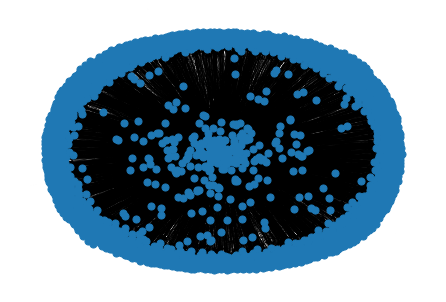

In [25]:
nx.draw(G, pos=nx.spring_layout(G), width = 0.5, node_size=50)

**Barabási-Albert with m=3:**

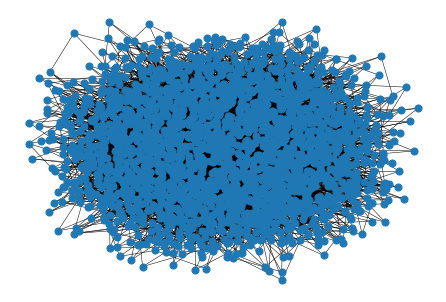

In [26]:
nx.draw(G_BarAl_1, pos=nx.spring_layout(G_BarAl_1), width = 0.5, node_size=50)

**Barabási-Albert with m=2237:**

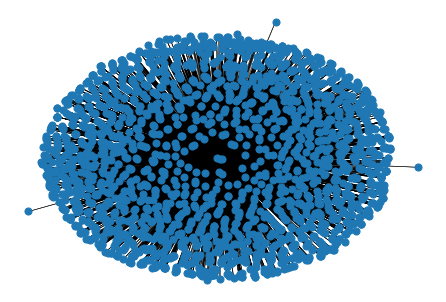

In [27]:
nx.draw(G_BarAl_2, pos=nx.spring_layout(G_BarAl_2), width = 0.5, node_size=50)

### Degree distribution

We will now compare the degree distribution of these networks. We already know that our network follows a power-law distribution.

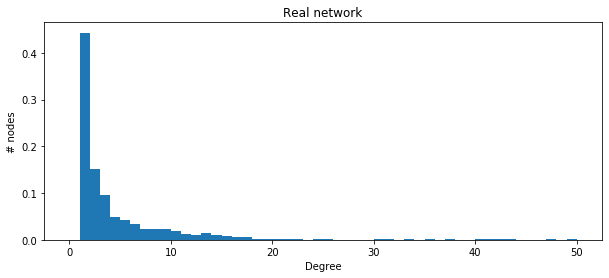

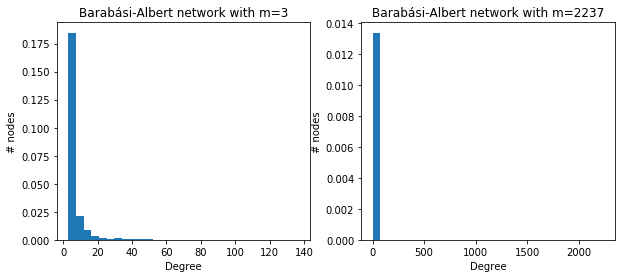

In [29]:
#Real network

f, ax = plt.subplots(1, 1, figsize=(10,4))
degrees = dict(G.degree()).values() 
degree_hist = ax.hist(list(degrees), 50, range=(0,50), density=True)
plt.xlabel('Degree')
plt.ylabel('# nodes')
plt.title('Real network')
plt.show


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
#Barabási-Albert network with m=2
degrees_BarAl_1 = sorted([d for n, d in G_BarAl_1.degree()], reverse=True) 
degree_hist_BarAl_1 = ax1.hist(list(degrees_BarAl_1), 30 , density=True)
ax1.set_xlabel('Degree')
ax1.set_ylabel('# nodes')
ax1.set_title('Barabási-Albert network with m=3')

#Barabási-Albert network with m=2238
degrees_BarAl_2 = sorted([d for n, d in G_BarAl_2.degree()], reverse=True) 
degree_hist_BarAl_2 = ax2.hist(list(degrees_BarAl_2), 30 , density=True)
ax2.set_xlabel('Degree')
ax2.set_ylabel('# nodes')
ax2.set_title('Barabási-Albert network with m=2237')


plt.show()

By looking at the histograms, we can see that their degree distributions are actually power-laws. Let us now plot the distributions in a log-log scale to see the decay of the distribution as the degree increases.

Slope of linear fit:  -2.422838637957744
Slope of linear fit:  -0.3406016156591876
Slope of linear fit:  -0.5103538817380344


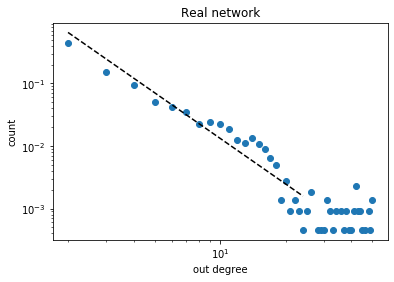

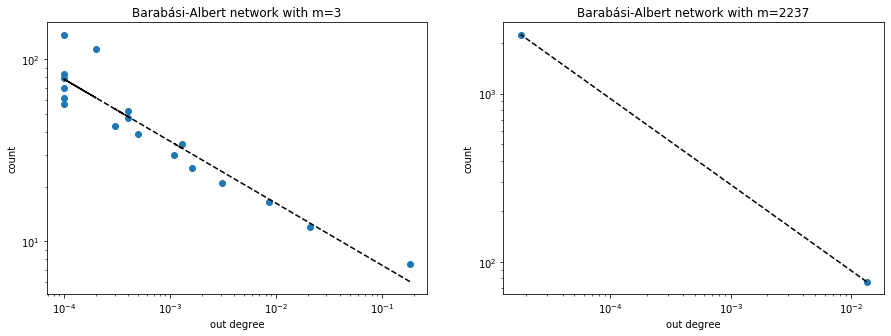

In [30]:
#Real network

coef = np.polyfit(np.log10(degree_hist[1][2:26]),np.log10(degree_hist[0][1:25]),1)
poly1d_fn = np.poly1d(coef) 

print('Slope of linear fit: ', coef[0])

f, ax = plt.subplots(1, 1)
ax.plot(degree_hist[1][2:],degree_hist[0][1:], 'o')
ax.plot(degree_hist[1][2:25], np.power(10,poly1d_fn(np.log10(degree_hist[1][2:25]))), '--k')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title("Real network")
ax.set_xlabel('out degree')
ax.set_ylabel('count')


#Barabási-Albert networks


deg_vals = degree_hist_BarAl_1[0]
count_vals = degree_hist_BarAl_1[1][1:]

idx = count_vals*deg_vals>0
coef = np.polyfit(np.log10(deg_vals[idx]),np.log10(count_vals[idx]),1)
poly1d_fn = np.poly1d(coef) 
print('Slope of linear fit: ', coef[0])

f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(deg_vals,count_vals, 'o')
ax1.plot(deg_vals[idx], np.power(10,poly1d_fn(np.log10(deg_vals[idx]))), '--k')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title("Barabási-Albert network with m=3")
ax1.set_xlabel('out degree')
ax1.set_ylabel('count')

#2
deg_vals = degree_hist_BarAl_2[0]
count_vals = degree_hist_BarAl_2[1][1:]

idx = count_vals*deg_vals>0
coef = np.polyfit(np.log10(deg_vals[idx]),np.log10(count_vals[idx]),1)
poly1d_fn = np.poly1d(coef) 
print('Slope of linear fit: ', coef[0])

ax2.plot(deg_vals,count_vals, 'o')
ax2.plot(deg_vals[idx], np.power(10,poly1d_fn(np.log10(deg_vals[idx]))), '--k')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title("Barabási-Albert network with m=2237")
ax2.set_xlabel('out degree')
ax2.set_ylabel('count')

plt.show()

Notice that the last histogram only has two points. This is due to the fact that the Barabási-Albert algorithm begins with 2238 nodes. Then, it adds one node and 2237 edges. This step is performed one more time. 

### Average length

We will compute the average shortest path lenght of the models. As we already did in the previous case, we will stick to the largest connected component for each graph.

In [31]:
#our network
largest_cc = max(nx.weakly_connected_components(G), key=len)
G_con = G.subgraph(largest_cc)
H = G_con.to_undirected()

#Small-world networks
largest_cc_BarAl_1 = max(nx.connected_components(G_BarAl_1), key=len)
G_con_BarAl_1 = G_BarAl_1.subgraph(largest_cc_BarAl_1)

largest_cc_BarAl_2 = max(nx.connected_components(G_BarAl_2), key=len)
G_con_BarAl_2 = G_BarAl_2.subgraph(largest_cc_BarAl_2)

print('Real network: Average shortest path lenght: ', nx.average_shortest_path_length(G_con))
print('Real network (undirected): Average shortest path lenght: ', nx.average_shortest_path_length(H))
print('Barabási-Albert network with m=3: Average shortest path lenght: ', nx.average_shortest_path_length(G_con_BarAl_1))
print('Barabási-Albert network with m=2237: Average shortest path lenght: ', nx.average_shortest_path_length(G_con_BarAl_2))


Real network: Average shortest path lenght:  0.018096339574896314
Real network (undirected): Average shortest path lenght:  3.843630365293458
Barabási-Albert network with m=3: Average shortest path lenght:  3.7908098321954955
Barabási-Albert network with m=2237: Average shortest path lenght:  1.9973238212212086


We observe that the average shortest path length of the Barabási-Albert networks is much larger than the average shortest path length from the real network. 

### Clustering coefficient

Finally, we will compare the clustering coefficient of the networks.

In [32]:
print('Real network: Average clustering coefficient:', nx.average_clustering(G))
print('Real network (undirected): Average clustering coefficient:', nx.average_clustering(G.to_undirected()))
print('Barabási-Albert network with m=3: Average clustering coefficient:', nx.average_clustering(G_BarAl_1))
print('Barabási-Albert network with m=2237: Average clustering coefficient:', nx.average_clustering(G_BarAl_2))

Real network: Average clustering coefficient: 0.022991199720053465
Real network (undirected): Average clustering coefficient: 0.03993454842752696
Barabási-Albert network with m=3: Average clustering coefficient: 0.01329557833081908
Barabási-Albert network with m=2237: Average clustering coefficient: 0.9986631064001465


In the random networks, the clustering coefficient is quite high. Notice the fact that such coefficient is almost 1 when m=2237. This makes sense since, in such case, the Barabási-Albert algorithm only performs two steps.

# 4. Communities

In this notebook we are going to study our network communities. 

The quality of a network partition can be measured by the partition **modularity**. Modularity is the fraction of the edges that fall within the given groups minus the expected fraction if edges were distributed at random. 

$$
Q = \sum_i (e_{ii} - a_i^2)
$$

where $e_{ij}$ is the fraction of the total number of links starting at a node in partition $i$ and ending at a node in partition $j$, and $a_i^2$ is the number of intracommunity links. The modularity falls into the range $[-1/2, 1]$. Higher values of modularity represent better partitions.

## 1. Louvain algorithm

An **optimal partition** is the one with highest modularity. In order to find this optimal partition, we will use **Louvain algorithm**. This algorithm roughly works as follows:

+ *First phase*: First, each node is assigned to its own community. Then, for each node $i$, the change in modularity ($\nabla Q$) is calculated for removing $i$ from its own community and adding it to a community of $j$, a neighbour of $i$. When $\nabla Q$ is calculated for all neighbours of $i$, $i$ is assigned to the neighbour $j$ with highest modularity increase. If no increase is possible, $i$ remains in its community. The process is repeated to all nodes until no modularity increase is achieved. 

+ *Second phase:* it groups all of the nodes in the same community and builds a new network where nodes are the communities from the previous phase. Any links between nodes of the same community are now represented by self-loops on the new community node and links from multiple nodes in the same community to a node in a different community are represented by weighted edges between communities. Once the new network is created, the second phase has ended and the first phase can be re-applied to the new network.

In [33]:
#Compute the best partition
#We have to transform the graph to undirected in order to compute the partition
H = G.to_undirected()
partition = community.best_partition(H)

#Compute the induced graph (the graph with nodes corresponding to partitions)
ind = community.induced_graph(partition, H)
num_part = ind.number_of_nodes()

print('Number of communities: ', num_part)

Number of communities:  24


The Louvain algorithm gave us 24 communities for the network. Let's visualize the nodes coloured according to the community.

### Partition visualization

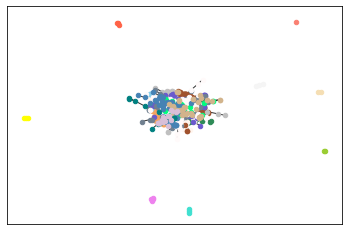

In [34]:
#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(H)
count = 0
cols = list(mcolors.CSS4_COLORS.values())[-num_part:]
for com in set(partition.values()) :
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(H, pos, list_nodes, node_size = 20,
                                node_color = cols[count])
    count +=1

nx.draw_networkx_edges(H, pos, alpha=0.8)
plt.show()

We observe that there are some isolated communities. The other communities are connected to each other.

In [35]:
print('The modularity of our graph is: ', community.modularity(partition, H))

The modularity of our graph is:  0.4679289826520382


We observe that the modularity of this partition is quite high. This means that we have found a good partition.

Now we will draw the induced grap, that is, the grap where each node is a community of the original graph.

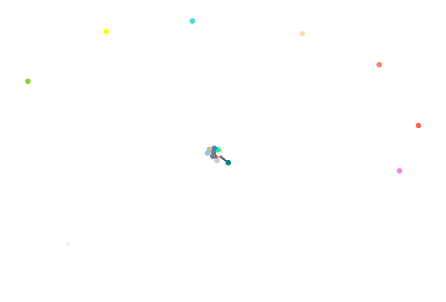

In [36]:
nx.draw(ind, pos=nx.spring_layout(ind), width = 0.5, 
        node_size=20, node_color = cols)

Again, we notice that there are some isolated communities surrounding a set of connected communities. 

### Number of nodes in the communities

Next, we will look at the number of nodes of each community, to see if they are equally distributed or not.

In [37]:
part_values = np.array(list(partition.values()))
list_nodes = np.array(H.nodes)


partition_nodes = []
num_nodes_part = []
for i in range(num_part):
    partition_nodes.append(frozenset(list_nodes[part_values==i]))
    num_nodes_part.append(len(list_nodes[part_values==i]))

Number of nodes in the communities:  [  1   2   2   2   3   3   3   3   4  13  22  44  48  49  56  80  82 110
 117 122 217 267 450 540]


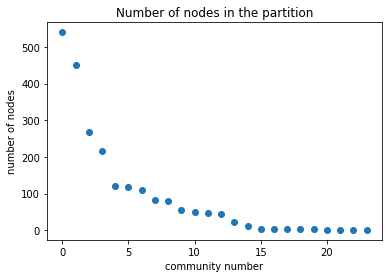

In [38]:
print('Number of nodes in the communities: ', np.array(sorted(num_nodes_part)))
idx = list(np.argsort(-np.array(num_nodes_part)))

plt.plot(np.arange(num_part), np.array(num_nodes_part)[idx], 'o')
plt.title('Number of nodes in the partition')
plt.xlabel('community number')
plt.ylabel('number of nodes')
plt.show()

Observe that there are 9 communities with less than 10 nodes. These communities are therefore isolated. There are some medium communities with 10-270 nodes and then two larger communities with 450 and 540 nodes each.